<a href="https://colab.research.google.com/github/MrckHckr/artemis2-go-tests/blob/main/notebooks%5C03_heat_shield.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Orion Heat Shield
# Obiettivo:
Verificare che lo scudo termico (Avcoat) resista al carico termico di rientro, non superi temperature critiche, non mostri degradazione anomala, dia GO / NO-GO per Artemis 2



In [1]:
# Import librerie
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

np.random.seed(42)


In [2]:
# Simulazione profilo di rientro
# Tempo di rientro (secondi)
time = np.arange(0, 900)

# Flusso termico (kW/m^2)
heat_flux = 1000 * np.exp(-((time - 450)**2) / (2 * 120**2))

# Temperatura scudo (°C)
shield_temp = 300 + 0.08 * heat_flux + np.random.normal(0, 15, len(time))

# Inseriamo anomalie simulate
shield_temp[520] += 400
shield_temp[610] += 300

# DataFrame
df_heat = pd.DataFrame({
    "time_s": time,
    "heat_flux_kw_m2": heat_flux,
    "shield_temp_c": shield_temp
})

df_heat.head()


,time_s,heat_flux_kw_m2,shield_temp_c
0,0,0.883826,307.521418
1,1,0.911850,297.998984
2,2,0.940698,309.790584
3,3,0.970390,322.923079
4,4,1.000950,296.567775


In [3]:
# Limiti fisici del materiale Avcoat
# Limiti di sicurezza
MAX_TEMP = 3300  # °C (Avcoat)
WARNING_TEMP = 3000

df_heat["over_limit"] = df_heat["shield_temp_c"] > MAX_TEMP
df_heat["warning"] = df_heat["shield_temp_c"] > WARNING_TEMP

print("Superamenti limite:", df_heat["over_limit"].sum())


Superamenti limite: 0


In [4]:
# Anomaly Detection (Isolation Forest)
# Preparazione dati
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_heat[["heat_flux_kw_m2", "shield_temp_c"]])

# Isolation Forest
model = IsolationForest(contamination=0.01, random_state=42)
df_heat["anomaly"] = model.fit_predict(X_scaled)

df_heat.head()


,time_s,heat_flux_kw_m2,shield_temp_c,over_limit,warning,anomaly
0,0,0.883826,307.521418,False,False,1
1,1,0.911850,297.998984,False,False,1
2,2,0.940698,309.790584,False,False,1
3,3,0.970390,322.923079,False,False,1
4,4,1.000950,296.567775,False,False,1


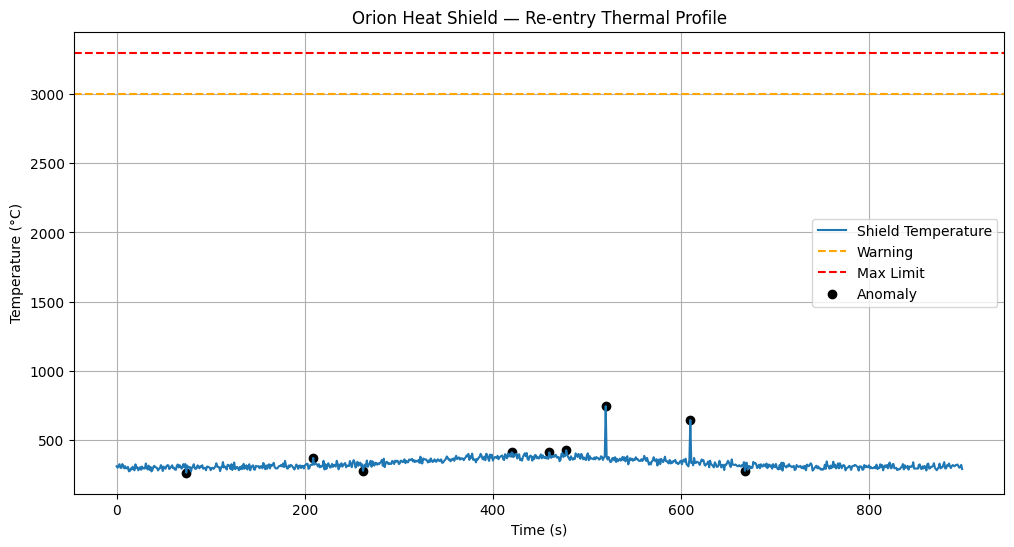

In [5]:
# Visualizzazione
plt.figure(figsize=(12,6))

plt.plot(df_heat["time_s"], df_heat["shield_temp_c"], label="Shield Temperature")
plt.axhline(3000, linestyle="--", color="orange", label="Warning")
plt.axhline(3300, linestyle="--", color="red", label="Max Limit")

plt.scatter(
    df_heat[df_heat["anomaly"] == -1]["time_s"],
    df_heat[df_heat["anomaly"] == -1]["shield_temp_c"],
    color="black",
    label="Anomaly"
)

plt.xlabel("Time (s)")
plt.ylabel("Temperature (°C)")
plt.title("Orion Heat Shield — Re-entry Thermal Profile")
plt.legend()
plt.grid(True)
plt.show()


In [6]:
# Decisione GO / NO-GO Heat Shield
# Regole di decisione
max_anomalies = 2
anomalies_detected = (df_heat["anomaly"] == -1).sum()
over_limit_events = df_heat["over_limit"].sum()

if over_limit_events > 0:
    decision = "❌ NO-GO — superato limite termico"
elif anomalies_detected > max_anomalies:
    decision = "❌ NO-GO — anomalie termiche eccessive"
else:
    decision = "✅ GO — scudo termico conforme"

print(decision)
print(f"Anomalie rilevate: {anomalies_detected}")
print(f"Superamenti limite: {over_limit_events}")


❌ NO-GO — anomalie termiche eccessive
Anomalie rilevate: 9
Superamenti limite: 0
